In [13]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib import style
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
import seaborn as sns
from scipy import signal
import cv2

style.use('seaborn-colorblind')
pd.set_option("display.max_rows", None)

C:\Users\user\AppData\Local\Temp\ipykernel_10596\2238182740.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')


# Define path and data to load

In [2]:
filename="./example_data.txt"
pir = "PIR03"
led = "LED03"

# Helper function for douple-plot actogram 

In [3]:
def double_plot(df, pir, led):

    dategroup = df.groupby(pd.Grouper(freq='D'))

    plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
    plt.rcParams['axes.xmargin'] = 0.
    plt.rcParams['axes.ymargin'] = 0.1
    plt.rcParams['axes.linewidth'] = 0.5 # axis thickness
    plt.rcParams['font.family'] = ['sans serif']
    plt.rcParams['font.size'] = 10

    n_group = dategroup.ngroups
    ### Double-plot actogram
    #fig = plt.figure()

    fig,axes = plt.subplots(n_group-1, 2)

    # Half-opaque grayscale colormap 
    # by Bart https://stackoverflow.com/questions/37327308/add-alpha-to-an-existing-matplotlib-colormap
    cmap = plt.cm.gray
    my_cmap = cmap(np.arange(cmap.N))
    my_cmap[:,-1] = np.linspace(0.2, 1, cmap.N)
    my_cmap = ListedColormap(my_cmap)

    # scale to 1000 if max PIR is 60
    max_val=np.clip(max(df[pir].values), a_min=1, a_max=max(df[pir].values))
    scale = 1000/max_val

    # Plot the 1st column    
    j = 0
    i = 0
    for name, group in dategroup:
        if j < n_group-1:
            (group[pir]*scale).plot.area(ax=axes[j, 0], cmap='gray', figsize=(3, 0.1*(n_group-1)))
            ((1-group[led])*1000).plot.area(linewidth=0, ax=axes[j, 0],
                                    cmap=my_cmap, sharey=True, sharex=True)
            axes[j, 0].axes.set_yticklabels([])
            axes[j, 0].axes.set_yticks([])
            loc = mdates.HourLocator(interval=12)
            axes[j, 0].xaxis.set_major_locator(loc)
            fmt = mdates.DateFormatter("%H")
            axes[j, 0].xaxis.set_major_formatter(fmt)
            axes[j, 0].axes.set_ylim(1,1000)
            axes[j, 0].axes.set_ylabel(
                str(group[pir].index.date[0].month) + '/' + str(group[pir].index.date[0].day) + ' ', rotation=0, size=9)
            
            axes[j, 0].axes.set_xlim([pd.to_datetime(group['MO/DY/YEAR'][0]+' ' + '00:00:00',
                                format="%m/%d/%Y %H:%M:%S"), pd.to_datetime(group['MO/DY/YEAR'][0]+' ' + '23:59:00',
                                format="%m/%d/%Y %H:%M:%S")])
            axes[j, 0].yaxis.set_label_coords(-0.125,0.0)
            # if j < n_group-2:
            x_axis = axes[j, 0].axes.get_xaxis()
            x_axis.set_visible(False)

            y_axis = axes[j, 0].axes.get_yaxis()
            y_axis.set_visible(False)
            axes[j, 0].spines['left'].set_visible(False) 


        if j >= 1 : 
            (group[pir]*scale).plot.area(ax=axes[i, 1], sharey=True, cmap='gray')
            ((1-group[led])*1000).plot.area(linewidth=0,
                                    cmap=my_cmap, ax=axes[i, 1], sharey=True)
            x_axis = axes[i, 1].axes.get_xaxis()
            x_axis.set_visible(False)
            axes[i, 1].axes.set_ylim(1,1000)
            axes[i, 1].axes.set_xlim([pd.to_datetime(group['MO/DY/YEAR'][0]+' ' + '00:00:00',
                                format="%m/%d/%Y %H:%M:%S"), pd.to_datetime(group['MO/DY/YEAR'][0]+' ' + '23:59:00',
                                format="%m/%d/%Y %H:%M:%S")])
            y_axis = axes[i, 1].axes.get_yaxis()
            y_axis.set_visible(False)
            # sns.despine(top=True, right=True, left=True)   
            axes[i, 1].spines['right'].set_visible(False) 
            
            axes[i, 1].spines['left'].set_color('k')
            axes[i, 1].spines['left'].set_linestyle((0,(4,4)))
            i = i+1
            sns.despine(top=True, left=False, right=False, bottom=False)

        j = j+1
    # create second Axes. Note the 0.0 height
    plt.axvline(x = 23, color = 'red', label = 'axvline - full height')
    fig.subplots_adjust(left=0.12, right=0.9,  bottom=0.2, wspace=0, hspace=0.01)
    
    ax2=axes[j-2, 1].inset_axes([-1, -0.2, 2, 0.])
    ax2.set_xticks([0,1,2], [0,24,48])
    ax2.set_xlim([0,2])
    ax2.set_xlabel("Hour of day")
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.yaxis.set_visible(False)
    
    return fig

# Read data into a pandas dataframe

In [4]:

number_of_skipped_lines = 0 # In the raw data, there are first few lines that contains scheduling data that we need to exclude

try:
    fo = open(filename, "r")

except:
    raise Exception("Cannot open " + filename)

for line in fo:
    
    if "HH:MM:SS" in line:
        break

    else:
        number_of_skipped_lines += 1 
fo.close()


df = pd.read_table(filename, sep='\s+', skip_blank_lines=True,
                skiprows=number_of_skipped_lines, index_col=None)


df.index = pd.to_datetime(df['MO/DY/YEAR']+' ' + df['HH:MM:SS'],
                        format="%m/%d/%Y %H:%M:%S") # Indexing dataframe with datetime

# We will need the data from 04/01/2022 to 05/31/2022 for the analzsis
df=df[(df['MO/DY/YEAR'] >= '04/01/2022') & (df['MO/DY/YEAR'] <= '05/31/2022')]

# Double-plot Actogram and Spectrogram

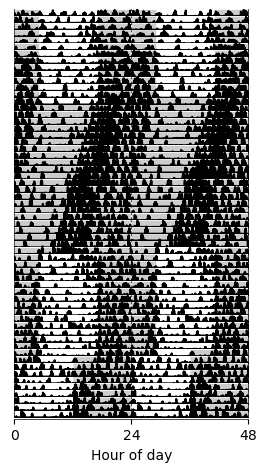

In [6]:
# Double-plot Actogram
fig=double_plot(df, pir, led)
fig.savefig("Fig3_Left.png", dpi=300)

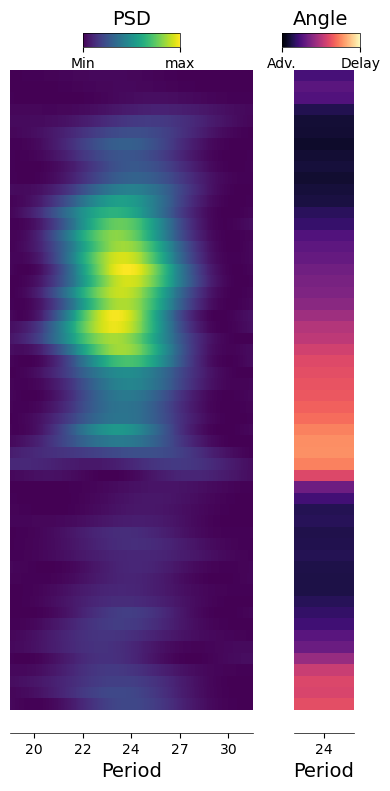

In [11]:
cycle1, trend1=sm.tsa.filters.hpfilter(df.loc[:,pir].values, lamb=5.184 * (10**7))
cycle2, trend2=sm.tsa.filters.hpfilter(trend1, lamb=5.184 * (10**9))
df.loc[:,"filter"]= cycle2
f, t, Sxx = signal.spectrogram(df.loc[:,"filter"], 60*24, nperseg=24*60*5, detrend=False, mode="psd", noverlap=24*60*4, nfft=24*60*5*100)

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=(4,8))

heatmap = ax[0].pcolormesh(f, t, Sxx.T, vmin = 0, vmax = 5000)

ax[0].set_xlim([18/24,30/24])
ax[0].set_ylabel("Recording duration (day)", fontsize=14)
ax[0].set_xlabel("Period", fontsize=14)
ax[0].set_xticks([0.8,0.9,1,1.1,1.2], [round(24/0.8),round(24/0.9),round(24),round(24/1.1),round(24/1.2)])
# ax[0].set_ylim(0,60)

axins = ax[0].inset_axes([0.3, 1, 0.4, 0.02])
cbar=fig.colorbar(heatmap, cax=axins,fraction=0.05, orientation="horizontal")
cbar.ax.set_title('PSD', fontsize=14)
cbar.set_ticks([0, 5000])
cbar.set_ticklabels(["Min", "max"])

ax[0].invert_yaxis()
ax[0].invert_xaxis()
ax[0].yaxis.set_visible(False)

f, t, Sxx = signal.spectrogram(cycle2,  60*24, nperseg=24*60*5 , detrend=False, mode="angle", noverlap=24*60*4, nfft=24*60*5*1)
heatmap=ax[1].pcolormesh(f, t, Sxx.T, cmap = "magma", vmin=0, vmax=4)
ax[1].set_xlim([22.8/24,25.2/24])
ax[1].set_ylabel("Days", fontsize=14)
ax[1].set_xlabel("Period", fontsize=14)
ax[1].set_xticks([1], [24])

axins = ax[1].inset_axes([-0.2, 1, 1.3, 0.02])
cbar=fig.colorbar(heatmap, cax=axins,fraction=0.05, orientation="horizontal")
cbar.ax.set_title('Angle', fontsize=14)
cbar.set_ticks([0, 4])
cbar.set_ticklabels(["Adv.", "Delay"])

ax[1].invert_yaxis()
ax[1].invert_xaxis()
ax[1].yaxis.set_visible(False)
sns.despine(left=True)

plt.tight_layout()
plt.savefig("Fig3_Middle_Right.png", dpi=300)

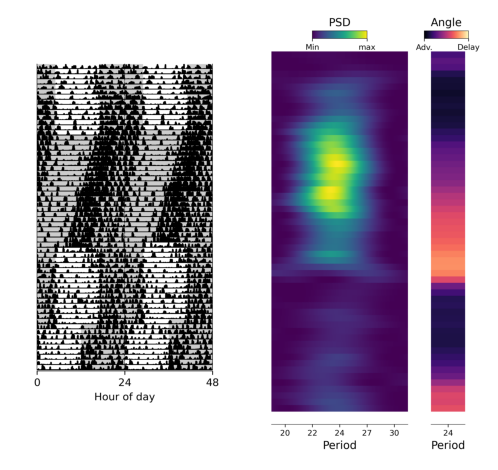

In [14]:
img1 = cv2.imread("Fig3_Left.png")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)


img2 = cv2.imread("Fig3_Middle_Right.png")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')
plt.subplots_adjust(left=0.12, right=1,  bottom=0.2, wspace=0, hspace=0.)
plt.tight_layout()
plt.savefig("Fig3.png", dpi=300)

# Note that in our publication, we aligned the left, middle, and right figures to the same Y-axis (Hour of day)

# EXTRA: PHASE ANGLE PLOTS FOR OTHER PERIODS

Text(0.5, 1.0, 'Angle with unwrapping)')

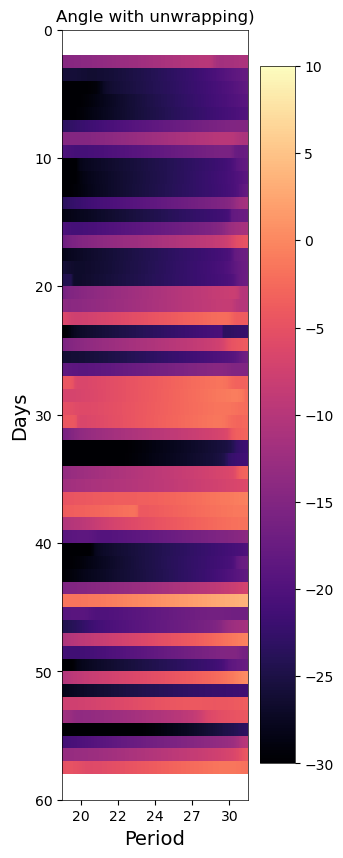

In [18]:
# As in our publication, the angle is only plotted for the 24-h period. To gain a better understanding, the readers might also want to look at the phase angle of other periods

plt.figure(figsize=(3,10))
f, t, Sxx = signal.spectrogram(cycle2,  60*24, nperseg=24*60*5 , detrend=False, mode="phase", noverlap=24*60*4, nfft=24*60*5*100)
plt.pcolormesh(f, t, Sxx.T, cmap = "magma", vmin=-30, vmax=10)
plt.colorbar()
plt.xlim([18/24,30/24])
plt.xticks([0.8,0.9,1,1.1,1.2], [round(24/0.8),round(24/0.9),round(24),round(24/1.1),round(24/1.2)])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.ylabel("Days", fontsize=14)
plt.xlabel("Period", fontsize=14)
plt.title("Angle with unwrapping)")

Text(0.5, 1.0, 'Phase (angle without unwrapping)')

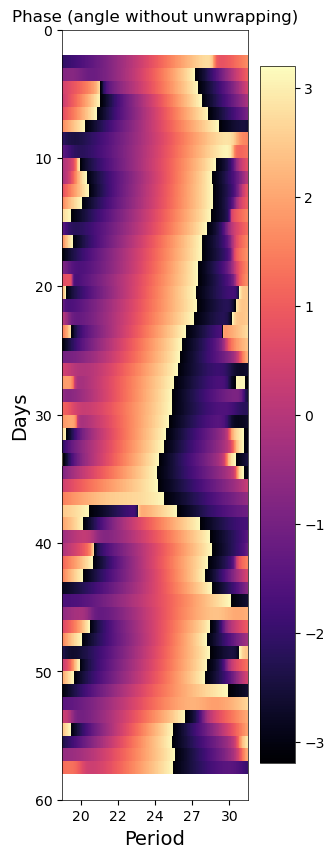

In [19]:
plt.figure(figsize=(3,10))
f, t, Sxx2 = signal.spectrogram(cycle2,  60*24, nperseg=24*60*5 , detrend=False, mode="angle", noverlap=24*60*4, nfft=24*60*5*100)
plt.pcolormesh(f, t, Sxx2.T, cmap = "magma", vmin=-3.2, vmax=3.2)
plt.colorbar()
plt.xlim([18/24,30/24])
plt.xticks([0.8,0.9,1,1.1,1.2], [round(24/0.8),round(24/0.9),round(24),round(24/1.1),round(24/1.2)])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.ylabel("Days", fontsize=14)
plt.xlabel("Period", fontsize=14)
plt.title("Phase (angle without unwrapping)")